# **Import**

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# !pip install keras-tcn
from tcn import TCN

from tensorflow.keras.callbacks import EarlyStopping

# **Data Load**

In [3]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [4]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD001.csv')

In [5]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# **Model**

In [6]:
def create_sequences(df, sensor_names, window_size=30, scaler=None):
    x, y = [], []
    df_scaled = df.copy()
    df_scaled[sensor_names] = scaler.fit_transform(df[sensor_names])

    for unit in df_scaled['unit_number'].unique():
        unit_data = df_scaled[df_scaled['unit_number'] == unit]
        sensors = unit_data[sensor_names].values
        rul = unit_data['RUL'].values

        for i in range(len(unit_data) - window_size):
            x.append(sensors[i:i+window_size])
            y.append(rul[i+window_size])

    return np.array(x), np.array(y)

In [7]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


## **LSTM**

In [ ]:
window_size = 30
sensor_names = [c for c in train_df.columns if 's_' in c]

scaler = MinMaxScaler()
scaler.fit(train_df[sensor_names])

x, y = create_sequences(train_df, sensor_names, window_size)

unit_ids = train_df['unit_number'].unique()
unit_groups = [unit_ids[i:i+10] for i in range(0, len(unit_ids), 10)]

In [ ]:
results = []
for fold_idx, val_units in enumerate(unit_groups, 1):
    print(f"\n=== Fold {fold_idx}: val_units = {val_units} ===")

    # train/val split (unit 단위)
    train_units = [u for u in unit_ids if u not in val_units]
    train_mask = train_df['unit_number'].isin(train_units)
    val_mask = train_df['unit_number'].isin(val_units)

    # 각 set에 대해 시퀀스 생성
    x_train, y_train = create_sequences(train_df[train_mask], sensor_names, window_size, scaler)
    x_val, y_val = create_sequences(train_df[val_mask], sensor_names, window_size, scaler)

    input_shape = (x_train.shape[1], x_train.shape[2])

    lstm_model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    lstm_model.fit(
        x_train,
        y_train,
        epochs=30,
        batch_size=64,
        validation_data=(x_val, y_val),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    lstm_pred = lstm_model.predict(x_val)
    lstm_rmse = np.sqrt(mean_squared_error(y_val, lstm_pred))
    lstm_mae = mean_absolute_error(y_val, lstm_pred)

    results.append({
        'fold': fold_idx,
        'val_units': val_units.tolist(),
        'LSTM_RMSE': lstm_rmse,
        'LSTM_MAE': lstm_mae,
    })
    print(f"RMSE: {lstm_rmse:.3f}, MAE: {lstm_mae:.3f}")


=== Fold 1: val_units = [ 1  2  3  4  5  6  7  8  9 10] ===
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 25.322, MAE: 18.514

=== Fold 2: val_units = [11 12 13 14 15 16 17 18 19 20] ===
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 26.702, MAE: 20.412

=== Fold 3: val_units = [21 22 23 24 25 26 27 28 29 30] ===
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 24.449, MAE: 18.604

=== Fold 4: val_units = [31 32 33 34 35 36 37 38 39 40] ===
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 20.681, MAE: 16.011

=== Fold 5: val_units = [41 42 43 44 45 46 47 48 49 50] ===
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 18.820, MAE: 13.912

=== Fold 6: val_units = [51 52 53 54 55 56 57 58 59 60] ===
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 30.135, MAE: 21.968

=== Fold 7: val_units = [61 62 63 64 65 66 67 68 69 70] ===
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 53.984, MAE: 40.392

=== Fold 8: val_units = [71 72 73 74 75 76 77 78 79 80] ===
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 23.741, MAE:

In [ ]:
results_df = pd.DataFrame(results)

print(results_df[['fold', 'LSTM_RMSE', 'LSTM_MAE',]])
print(results_df[['LSTM_RMSE', 'LSTM_MAE']].mean())

   fold  LSTM_RMSE   LSTM_MAE
0     1  25.322216  18.513514
1     2  26.701644  20.412222
2     3  24.449492  18.603502
3     4  20.680744  16.010683
4     5  18.819810  13.911692
5     6  30.135147  21.968159
6     7  53.983622  40.391644
7     8  23.740806  17.440130
8     9  36.543688  27.879942
9    10  45.061706  30.429375
LSTM_RMSE    30.543887
LSTM_MAE     22.556086
dtype: float64


## **TCN**

In [ ]:
window_size = 30
sensor_names = [c for c in train_df.columns if 's_' in c]

scaler = MinMaxScaler()
scaler.fit(train_df[sensor_names])

x, y = create_sequences(train_df, sensor_names, window_size, scaler)

unit_ids = train_df['unit_number'].unique()
unit_groups = [unit_ids[i:i+10] for i in range(0, len(unit_ids), 10)]

In [ ]:
results = []
for fold_idx, val_units in enumerate(unit_groups, 1):
    print(f"\n=== Fold {fold_idx}: val_units = {val_units} ===")

    train_units = [u for u in unit_ids if u not in val_units]
    train_mask = train_df['unit_number'].isin(train_units)
    val_mask = train_df['unit_number'].isin(val_units)

    x_train, y_train = create_sequences(train_df[train_mask], sensor_names, window_size)
    x_val, y_val = create_sequences(train_df[val_mask], sensor_names, window_size)

    input_shape = (x_train.shape[1], x_train.shape[2])

    tcn_model = Sequential([
        TCN(
            input_shape=(window_size, len(sensor_names)),
            nb_filters=64,
            kernel_size=3,
            dilations=[1, 2, 4, 8],
            dropout_rate=0.1,
            activation='relu',
            use_skip_connections=True,
            return_sequences=False
        ),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    tcn_model.compile(optimizer='adam', loss='mse')

    tcn_model.fit(
        x_train,
        y_train,
        epochs=30,
        batch_size=64,
        validation_data=(x_val, y_val),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    tcn_pred = tcn_model.predict(x_val)
    tcn_rmse = np.sqrt(mean_squared_error(y_val, tcn_pred))
    tcn_mae = mean_absolute_error(y_val, tcn_pred)

    results.append({
        'fold': fold_idx,
        'val_units': val_units.tolist(),
        'TCN_RMSE': tcn_rmse,
        'TCN_MAE': tcn_mae
    })
    print(f"RMSE: {tcn_rmse:.3f}, MAE: {tcn_mae:.3f}")


=== Fold 1: val_units = [ 1  2  3  4  5  6  7  8  9 10] ===
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
RMSE: 29.867, MAE: 21.631

=== Fold 2: val_units = [11 12 13 14 15 16 17 18 19 20] ===
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
RMSE: 25.011, MAE: 18.581

=== Fold 3: val_units = [21 22 23 24 25 26 27 28 29 30] ===
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
RMSE: 23.154, MAE: 17.358

=== Fold 4: val_units = [31 32 33 34 35 36 37 38 39 40] ===
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
RMSE: 18.853, MAE: 13.444

=== Fold 5: val_units = [41 42 43 44 45 46 47 48 49 50] ===
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
RMSE: 19.776, MAE: 15.062

=== Fold 6: val_units = [51 52 53 54 55 56 57 58 59 60] ===
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
RMSE: 27.728, MAE: 20.542

=== Fold 7: val_units = [61 62 63 64 65 66 67 68 69 70] ===
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 48.781, MAE: 33.318

=== Fold 8: val_units = [71 72 73 74 75 76 77 78 79 80] ===
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
RMSE: 21.76

In [ ]:
results_df = pd.DataFrame(results)

print(results_df[['fold',  'TCN_RMSE', 'TCN_MAE']])
print(results_df[[ 'TCN_RMSE', 'TCN_MAE']].mean())

   fold   TCN_RMSE    TCN_MAE
0     1  29.866884  21.631336
1     2  25.010589  18.580933
2     3  23.153812  17.357952
3     4  18.853185  13.444126
4     5  19.776195  15.061732
5     6  27.727795  20.541857
6     7  48.781373  33.317913
7     8  21.765390  15.957489
8     9  29.814133  21.753754
9    10  44.272776  28.151377
TCN_RMSE    28.902213
TCN_MAE     20.579847
dtype: float64


# **Predict RUL**

In [8]:
window_size = 30
clip_value = 125
sensor_names = [c for c in train_df.columns if 's_' in c]

unit_ids = train_df['unit_number'].unique()

In [9]:
scaler = MinMaxScaler()
scaler.fit(train_df[sensor_names])

train_units, val_units = train_test_split(unit_ids, test_size=0.2, random_state=42)

train_mask = train_df['unit_number'].isin(train_units)
val_mask = train_df['unit_number'].isin(val_units)

x_train, y_train = create_sequences(train_df[train_mask], sensor_names, window_size, scaler)
x_val, y_val = create_sequences(train_df[val_mask], sensor_names, window_size, scaler)

In [10]:
input_shape = (x_train.shape[1], x_train.shape[2])

final_lstm = Sequential([
    LSTM(64, input_shape=input_shape, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
final_lstm.compile(optimizer='adam', loss='mae')

final_lstm.fit(
    x_train, y_train,
    epochs=500,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 79.7272 - val_loss: 48.5090
Epoch 2/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 51.0096 - val_loss: 48.3512
Epoch 3/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 49.9992 - val_loss: 46.0147
Epoch 4/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 38.9881 - val_loss: 23.9601
Epoch 5/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.7168 - val_loss: 22.8567
Epoch 6/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.6348 - val_loss: 28.6658
Epoch 7/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 22.5919 - val_loss: 25.1750
Epoch 8/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21.8026 - val_loss: 20.5973
Epoch 9/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 21.4928 - val_loss: 17.3474
Epoch 10/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 21.7994 - val_loss: 25.9367
Epoch 11/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.5273 - val_loss: 27.7988
Epoch 12/500
222/22

In [11]:
final_tcn = Sequential([
    TCN(input_shape=input_shape,
        nb_filters=64, kernel_size=3, dilations=[1,2,4,8],
        dropout_rate=0.1, activation='relu', use_skip_connections=True,
        return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
final_tcn.compile(optimizer='adam', loss='mae')

final_tcn.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 44.7853 - val_loss: 23.8758
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 28.1774 - val_loss: 21.4577
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 25.5469 - val_loss: 18.8317
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.9741 - val_loss: 18.3641
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.3697 - val_loss: 19.8069
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.8072 - val_loss: 21.2442
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.0214 - val_loss: 20.1012
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 22.5884 - val_loss: 20.3926
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 22.5038 - val_loss: 22.7631


In [12]:
x_all, y_all = create_sequences(train_df, sensor_names, window_size, scaler)
lstm_pred_all = final_lstm.predict(x_all, verbose=1)
tcn_pred_all = final_tcn.predict(x_all, verbose=1)

551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


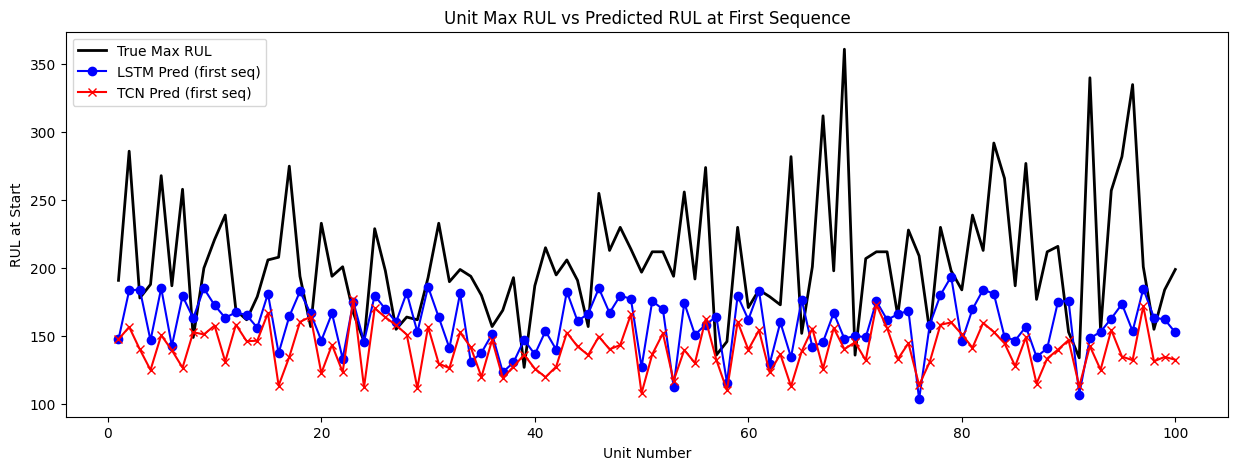

In [13]:
unit_ids = train_df['unit_number'].unique()

true_max_rul = []
lstm_rul_start = []
tcn_rul_start = []

start_idx = 0
for unit in unit_ids:
    unit_len = len(train_df[train_df['unit_number'] == unit])

    max_rul = train_df[train_df['unit_number'] == unit]['RUL'].max()
    true_max_rul.append(max_rul)

    first_seq_idx = start_idx
    lstm_rul_start.append(lstm_pred_all[first_seq_idx][0])
    tcn_rul_start.append(tcn_pred_all[first_seq_idx][0])

    start_idx += unit_len - window_size

df_max = pd.DataFrame({
    'unit_number': unit_ids,
    'True_Max_RUL': true_max_rul,
    'LSTM_FirstSeq_RUL': lstm_rul_start,
    'TCN_FirstSeq_RUL': tcn_rul_start
})

plt.figure(figsize=(15,5))
plt.plot(df_max['unit_number'], df_max['True_Max_RUL'], label='True Max RUL', color='black', linewidth=2)
plt.plot(df_max['unit_number'], df_max['LSTM_FirstSeq_RUL'], label='LSTM Pred (first seq)', color='blue', marker='o')
plt.plot(df_max['unit_number'], df_max['TCN_FirstSeq_RUL'], label='TCN Pred (first seq)', color='red', marker='x')
plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.show()

# **Test**

In [14]:
test_df = pd.read_csv('./test_FD001.csv')
rul_df = pd.read_csv('./RUL_FD001.csv')

In [15]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [16]:
sensor_names = [c for c in test_df.columns if 's_' in c]
window_size = 30

def create_test_sequences(df, sensor_names, window_size, scaler):
    x_test, y_test = [], []
    df_scaled = df.copy()
    df_scaled[sensor_names] = scaler.fit_transform(df[sensor_names])

    unit_max_rul = []

    for unit in df_scaled['unit_number'].unique():
        unit_data = df_scaled[df_scaled['unit_number'] == unit]
        sensors = unit_data[sensor_names].values
        rul = np.arange(len(unit_data)-1, -1, -1)  # Test set RUL: 마지막부터 1씩 감소

        # window_size 마지막 시퀀스만 사용 (혹은 sliding 가능)
        if len(unit_data) >= window_size:
            x_test.append(sensors[-window_size:])
            y_test.append(rul[-1])  # 마지막 시점 RUL
        else:
            # window_size보다 작은 경우 패딩 (앞쪽 반복)
            pad = np.repeat(sensors[0:1], window_size - len(unit_data), axis=0)
            x_test.append(np.vstack([pad, sensors]))
            y_test.append(rul[-1])

        unit_max_rul.append(rul[-1])

    return np.array(x_test), np.array(y_test), unit_max_rul

x_test_seq, y_test_seq, unit_max_rul = create_test_sequences(test_df, sensor_names, window_size, scaler)

In [17]:
y_test = rul_df['RUL']

In [18]:
lstm_pred_test = final_lstm.predict(x_test_seq)

lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred_test))
lstm_mae = mean_absolute_error(y_test, lstm_pred_test)
print(f"RMSE: {lstm_rmse:.3f}, MAE: {lstm_mae:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
RMSE: 32.204, MAE: 26.555


In [19]:
tcn_pred_test = final_tcn.predict(x_test_seq)

tcn_rmse = np.sqrt(mean_squared_error(y_test, tcn_pred_test))
tcn_mae = mean_absolute_error(y_test, tcn_pred_test)
print(f"RMSE: {tcn_rmse:.3f}, MAE: {tcn_mae:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
RMSE: 27.635, MAE: 21.021


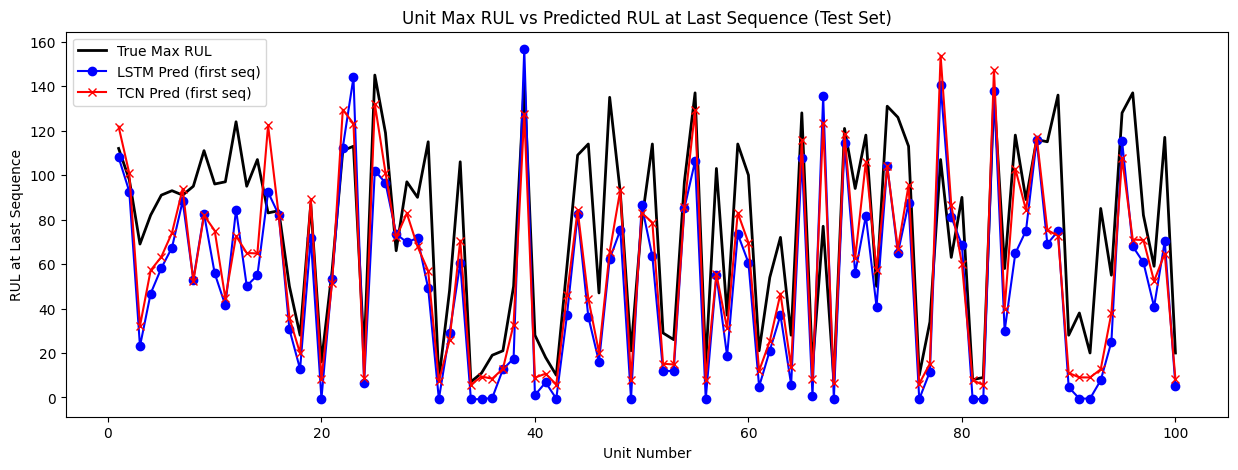

In [20]:
unit_ids = test_df['unit_number'].unique()

true_max_rul = rul_df['RUL'].values.tolist()  # Test set 실제 RUL
lstm_rul_start = []
tcn_rul_start = []

start_idx = 0
for unit in unit_ids:
    # unit별 시퀀스 개수
    unit_len = len(x_test_seq[start_idx:]) if len(x_test_seq[start_idx:]) == 1 else 1  # 마지막 시퀀스만 사용
    lstm_rul_start.append(lstm_pred_test[start_idx][0])
    tcn_rul_start.append(tcn_pred_test[start_idx][0])
    start_idx += unit_len

df_max = pd.DataFrame({
    'unit_number': unit_ids,
    'True_Max_RUL': true_max_rul,
    'LSTM_FirstSeq_RUL': lstm_rul_start,
    'TCN_FirstSeq_RUL': tcn_rul_start
})

plt.figure(figsize=(15,5))
plt.plot(df_max['unit_number'], df_max['True_Max_RUL'], label='True Max RUL', color='black', linewidth=2)
plt.plot(df_max['unit_number'], df_max['LSTM_FirstSeq_RUL'], label='LSTM Pred (first seq)', color='blue', marker='o')
plt.plot(df_max['unit_number'], df_max['TCN_FirstSeq_RUL'], label='TCN Pred (first seq)', color='red', marker='x')
plt.xlabel('Unit Number')
plt.ylabel('RUL at Last Sequence')
plt.title('Unit Max RUL vs Predicted RUL at Last Sequence (Test Set)')
plt.legend()
plt.show()